How to get list of CPU and GPUs ?

In [37]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_gpus()

[u'/cpu:0',
 u'/gpu:0',
 u'/gpu:1',
 u'/gpu:2',
 u'/gpu:3',
 u'/device:XLA_GPU:0',
 u'/device:XLA_CPU:0']

What is __XLA__?
XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that optimizes TensorFlow computations. The results are improvements in speed, memory usage, and portability on server and mobile platforms. Initially, most users will not see large benefits from XLA, but are welcome to experiment by using XLA via just-in-time (JIT) compilation or ahead-of-time (AOT) compilation. Developers targeting new hardware accelerators are especially encouraged to try out XLA.

The XLA framework is experimental and in active development. In particular, while it is unlikely that the semantics of existing operations will change, it is expected that more operations will be added to cover important use cases. The team welcomes feedback from the community about missing functionality and community contributions via GitHub.

In [38]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime


I also recommend logging device placement when using GPUs, at this lets you easily debug issues relating to different device usage. This prints the usage of devices to the log, allowing you to see when devices change and how that affects the graph.



In [40]:
time_values_2 = []
#device_name = "/gpu:0"
for i in range (100):
    shape = (20*i,20*i)


    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)
    
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        startTime = datetime.now()
        result = session.run(sum_operation)
    td = datetime.now() - startTime
    time_values_2.append(td.microseconds)
    if i%10 == 0:
        print i
    #print("Time taken:", datetime.now() - startTime)

0
10
20
30
40
50
60
70
80
90


In [ ]:
time_values_1 = []
device_name = "/cpu:0"
for i in range (100):
    shape = (20*i,20*i)

    with tf.device(device_name):
        random_matrix = tf.random_uniform(shape=(2,2), minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        startTime = datetime.now()
        result = session.run(sum_operation)
    td = datetime.now() - startTime
    time_values_1.append(td.microseconds)
    if i%10 == 0:
        print i
    #print("Time taken:", datetime.now() - startTime)

In [41]:
time_values_3 = []
device_name = "/gpu:0"
for i in range (100):
    shape = (20*i,20*i)

    with tf.device(device_name):
        random_matrix = tf.random_uniform(shape=(2,2), minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        startTime = datetime.now()
        result = session.run(sum_operation)
    td = datetime.now() - startTime
    time_values_3.append(td.microseconds)
    if i%10 == 0:
        print i
    #print("Time taken:", datetime.now() - startTime)

0
10
20
30
40
50
60
70
80
90


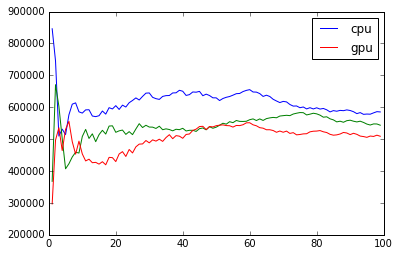

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(time_values_1[0:i]) for i in range(len(time_values_1))], label='cpu')
plt.plot([np.mean(time_values_2[0:i]) for i in range(len(time_values_2))], label = 'auto')
plt.plot([np.mean(time_values_3[0:i]) for i in range(len(time_values_3))], label='gpu')
plt.legend(loc='best')
plt.show()

# Exercise

Try running the previous exercise solutions on the GPU. Which operations can be performed on a GPU, and which cannot?
3) Build a program that uses operations on both the GPU and the CPU. Use the profiling code we saw in Lesson 5 to estimate the impact of sending data to, and retrieving data from, the GPU.

In [53]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time

device_times = {
    "/gpu:0":[],
    "/cpu:0":[]
}
matrix_sizes = range(500,1000,50)

for size in matrix_sizes:
    for device_name in device_times.keys():
        print (size)
        print("####### Calculating on the " + device_name + " #######")

        shape = (size,size)
        data_type = tf.float16
        with tf.device(device_name):
            r1 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
            r2 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
            dot_operation = tf.matmul(r2, r1)


        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
                start_time = time.time()
                result = session.run(dot_operation)
                time_taken = time.time() - start_time
                #print(result)
                device_times[device_name].append(time_taken)





500
####### Calculating on the /gpu:0 #######
500
####### Calculating on the /cpu:0 #######
550
####### Calculating on the /gpu:0 #######
550
####### Calculating on the /cpu:0 #######
600
####### Calculating on the /gpu:0 #######
600
####### Calculating on the /cpu:0 #######
650
####### Calculating on the /gpu:0 #######
650
####### Calculating on the /cpu:0 #######
700
####### Calculating on the /gpu:0 #######
700
####### Calculating on the /cpu:0 #######
750
####### Calculating on the /gpu:0 #######
750
####### Calculating on the /cpu:0 #######
800
####### Calculating on the /gpu:0 #######
800
####### Calculating on the /cpu:0 #######
850
####### Calculating on the /gpu:0 #######
850
####### Calculating on the /cpu:0 #######
900
####### Calculating on the /gpu:0 #######
900
####### Calculating on the /cpu:0 #######
950
####### Calculating on the /gpu:0 #######
950
####### Calculating on the /cpu:0 #######


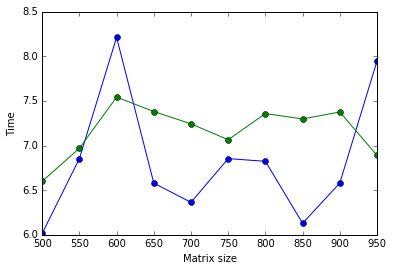

In [54]:

gpu_times = device_times["/gpu:0"]
cpu_times = device_times["/cpu:0"]

plt.plot(matrix_sizes[:len(gpu_times)], gpu_times, 'o-')
plt.plot(matrix_sizes[:len(cpu_times)], cpu_times, 'o-')
plt.ylabel('Time')
plt.xlabel('Matrix size')
plt.show()


# Using Multi GPUs

In [55]:
# Creates a graph.
c = []
for d in ['/gpu:2', '/gpu:3']:
  with tf.device(d):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
    c.append(tf.matmul(a, b))
with tf.device('/cpu:0'):
  sum = tf.add_n(c)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(sum))

[[  44.   56.]
 [  98.  128.]]
